In [8]:
import matplotlib
import matplotlib.pyplot as plt

import jax
import jax.numpy as np
from jax.random import PRNGKey

import numpyro
import numpyro.distributions as dist
from numpyro.infer import MCMC, NUTS, Predictive

import pandas as pd

from models import SEIR_hierarchical, plot_samples, plot_forecast, plot_R0
import util


def gen_covariates(places=None, num_places=5, intercept=False, drop_first=True):
    if places is None:
        places = [f'{i}' for i in range(num_places)]
    places = pd.DataFrame({'place': places})
    covariates = pd.get_dummies(places, drop_first=drop_first)
    if intercept:
        covariates['intercept'] = 1
    return covariates

In [9]:
Xy, place_data = util.load_state_Xy()

display(Xy)

positive  negative  pending  hospitalizedCurrently  \
state date                                                             
AK    2020-03-04       NaN       NaN      NaN                    NaN   
      2020-03-05       NaN       NaN      NaN                    NaN   
      2020-03-06       0.0       8.0      1.0                    NaN   
      2020-03-07       0.0      12.0      2.0                    NaN   
      2020-03-08       0.0      14.0      6.0                    NaN   
...                    ...       ...      ...                    ...   
WY    2020-04-11     261.0    5198.0      NaN                    NaN   
      2020-04-12     261.0    5198.0      NaN                    NaN   
      2020-04-13     275.0    5689.0      NaN                    NaN   
      2020-04-14     275.0    5689.0      NaN                    NaN   
      2020-04-15     287.0    6042.0      NaN                    NaN   

                  hospitalizedCumulative  inIcuCurrently  inIcuCumulative  \
state date                                                                  
AK    2020-03-04                     NaN             NaN              NaN   
      2020-03-05                     NaN             NaN              NaN   
      2020-03-06                     NaN             NaN              NaN   
      2020-03-07                     NaN             NaN              NaN   
      2020-03-08                     NaN             NaN              NaN   
...                                  ...             ...              ...   
WY    2020-04-11                    37.0             NaN              NaN   
      2020-04-12                    40.0             NaN              NaN   
      2020-04-13                    41.0             NaN              NaN   
      2020-04-14                    43.0             NaN              NaN   
      2020-04-15                    43.0             NaN              NaN   

                  onVentilatorCurrently  onVentilatorCumulative  recovered  \
state date                                                                   
AK    2020-03-04                    NaN                     NaN        NaN   
      2020-03-05                    NaN                     NaN        NaN   
      2020-03-06                    NaN                     NaN        NaN   
      2020-03-07                    NaN                     NaN        NaN   
      2020-03-08                    NaN                     NaN        NaN   
...                                 ...                     ...        ...   
WY    2020-04-11                    NaN                     NaN      129.0   
      2020-04-12                    NaN                     NaN      137.0   
      2020-04-13                    NaN                     NaN      138.0   
      2020-04-14                    NaN                     NaN      140.0   
      2020-04-15                    NaN                     NaN      129.0   

                  ... well_being animal_distancing  \
state date        ...                                
AK    2020-03-04  ...          0                 0   
      2020-03-05  ...          0                 0   
      2020-03-06  ...          0                 0   
      2020-03-07  ...          0                 0   
      2020-03-08  ...          0                 0   
...               ...        ...               ...   
WY    2020-04-11  ...          0                 0   
      2020-04-12  ...          0                 0   
      2020-04-13  ...          0                 0   
      2020-04-14  ...          0                 0   
      2020-04-15  ...          0                 0   

                  non_contact_infrastructure  prohibit_travel  \
state date                                                      
AK    2020-03-04                           0                0   
      2020-03-05                           0                0   
      2020-03-06                           0                0   
      2020-03-07                    

In [10]:
end = Xy.index.unique(level=1).max()
end_minus_one = end - pd.Timedelta("1d")
n_end = (Xy.index.get_level_values(1) == end).sum()
n_end_minus_one = (Xy.index.get_level_values(1) == end_minus_one).sum()

print(len(Xy))

if n_end < n_end_minus_one:
    Xy = Xy.loc[(slice(None), slice(None, end)), :]

alldata = Xy.join(place_data.drop(columns='state'), how='inner').sort_index()
display(Xy)

2365


positive  negative  pending  hospitalizedCurrently  \
state date                                                             
AK    2020-03-04       NaN       NaN      NaN                    NaN   
      2020-03-05       NaN       NaN      NaN                    NaN   
      2020-03-06       0.0       8.0      1.0                    NaN   
      2020-03-07       0.0      12.0      2.0                    NaN   
      2020-03-08       0.0      14.0      6.0                    NaN   
...                    ...       ...      ...                    ...   
WY    2020-04-11     261.0    5198.0      NaN                    NaN   
      2020-04-12     261.0    5198.0      NaN                    NaN   
      2020-04-13     275.0    5689.0      NaN                    NaN   
      2020-04-14     275.0    5689.0      NaN                    NaN   
      2020-04-15     287.0    6042.0      NaN                    NaN   

                  hospitalizedCumulative  inIcuCurrently  inIcuCumulative  \
state date                                                                  
AK    2020-03-04                     NaN             NaN              NaN   
      2020-03-05                     NaN             NaN              NaN   
      2020-03-06                     NaN             NaN              NaN   
      2020-03-07                     NaN             NaN              NaN   
      2020-03-08                     NaN             NaN              NaN   
...                                  ...             ...              ...   
WY    2020-04-11                    37.0             NaN              NaN   
      2020-04-12                    40.0             NaN              NaN   
      2020-04-13                    41.0             NaN              NaN   
      2020-04-14                    43.0             NaN              NaN   
      2020-04-15                    43.0             NaN              NaN   

                  onVentilatorCurrently  onVentilatorCumulative  recovered  \
state date                                                                   
AK    2020-03-04                    NaN                     NaN        NaN   
      2020-03-05                    NaN                     NaN        NaN   
      2020-03-06                    NaN                     NaN        NaN   
      2020-03-07                    NaN                     NaN        NaN   
      2020-03-08                    NaN                     NaN        NaN   
...                                 ...                     ...        ...   
WY    2020-04-11                    NaN                     NaN      129.0   
      2020-04-12                    NaN                     NaN      137.0   
      2020-04-13                    NaN                     NaN      138.0   
      2020-04-14                    NaN                     NaN      140.0   
      2020-04-15                    NaN                     NaN      129.0   

                  ... well_being animal_distancing  \
state date        ...                                
AK    2020-03-04  ...          0                 0   
      2020-03-05  ...          0                 0   
      2020-03-06  ...          0                 0   
      2020-03-07  ...          0                 0   
      2020-03-08  ...          0                 0   
...               ...        ...               ...   
WY    2020-04-11  ...          0                 0   
      2020-04-12  ...          0                 0   
      2020-04-13  ...          0                 0   
      2020-04-14  ...          0                 0   
      2020-04-15  ...          0                 0   

                  non_contact_infrastructure  prohibit_travel  \
state date                                                      
AK    2020-03-04                           0                0   
      2020-03-05                           0                0   
      2020-03-06                           0                0   
      2020-03-07                    

# Dev: Hierarchical Model

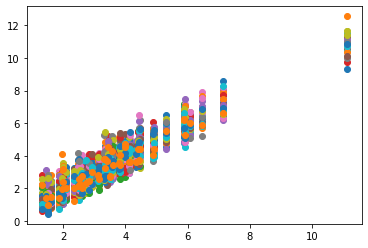

In [2]:
from functools import partial
from glm import glm, GLM, log_link, Gamma

def test_glm():

    data, place_data = util.load_state_Xy()
    alldata = data.join(place_data.drop(columns='state'), how='inner').sort_index()
    
    num_places = len(alldata.index.unique(level=0))
    
    with numpyro.handlers.seed(rng_seed=2):

        model = GLM('1 + C(state, OneHot) + standardize(popdensity)', 
                  alldata,
                  log_link,
                  partial(Gamma, var=0.3),
                  prior=dist.Normal(0, 0.5),
                  guess=3.5,
                  name="R0")
        
        R0, mu, pred = model.sample(shape=(num_places,-1))
        
    plt.plot(mu, R0, 'o')
    plt.show()
    
test_glm()


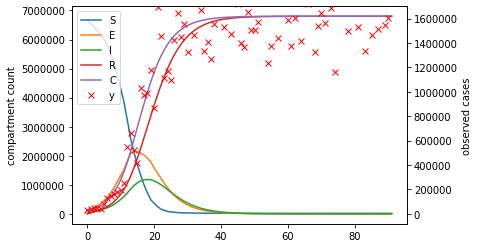

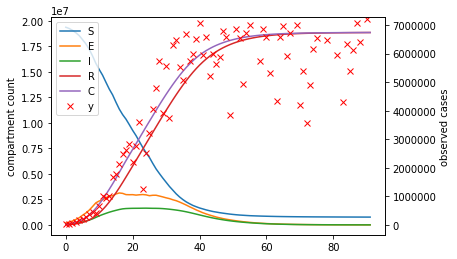

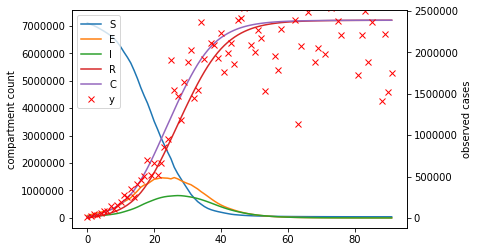

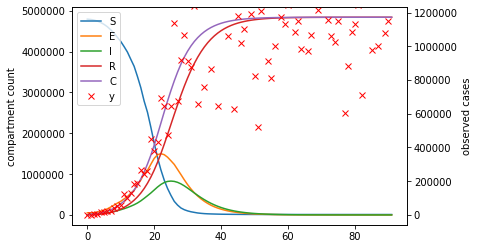

In [7]:
i = 1
num_places = 10
T = 50
T_future = 50
log_scale=False

states = ['MA', 'NY', 'WA', 'AL']
data, place_data = util.load_state_Xy(which=states)
data = data.join(place_data.drop(columns='state'), how='inner')

with numpyro.handlers.seed(rng_seed=i):
    
    beta, xx, yy, oo = SEIR_hierarchical(data=data,
                                         place_data = place_data,
                                         T_future=50)

for x, y, obs_rate in zip(xx, yy, oo):

    T = x.shape[0]
    ts = np.arange(T)

    fig, ax1 = plt.subplots()
    ax2 = ax1.twinx()

    l1 = ax1.plot(ts, x)
    l2 = ax2.plot(ts, y, 'x', color='r')

    plt.legend(l1 + l2, ['S', 'E', 'I', 'R', 'C', 'y'])

    ax1.set_ylabel('compartment count')
    ax2.set_ylabel('observed cases')

    if log_scale:
        ax1.set_yscale('log')
        ax2.set_yscale('log')

    ylim = np.array(ax1.get_ylim())
    ax2.set_ylim(obs_rate * ylim )

    plt.show()

In [ ]:
#def test_prior_predictive():

states = None
states = ['MA', 'NY', 'WA', 'AL']
data, place_data = util.load_state_Xy(which=states)
data = data.join(place_data.drop(columns='state'), how='inner')

data = data.loc[states,:]
place_data = place_data.loc[states,:]


predictive = Predictive(SEIR_hierarchical, 
                        posterior_samples = {}, 
                        num_samples=1000)

samples = predictive(PRNGKey(2), data, place_data, T_future=50)


In [ ]:
from models import plot_samples

display(place_data)

num_places = len(states)

for i in range(num_places):

    shared_params = ['gamma_', 'beta_', 'det_rate_']
    place_samples = {k: v[:,i,...] for k, v in samples.items() if not k in shared_params}
    plot_samples(place_samples, T=200, plot_fields=['I', 'y'])
    plt.title('Prior predictive')
    plt.yscale('log') 
    plt.show()
# for i in range(2):
#     test_prior(i, num_places=3, T=50, T_future=50, N=1e8)
#test_prior_predictive()

# Run Inference

In [ ]:
#states = ['MA', 'NY', 'WA', 'AL']
states = ['MA', 'NY']
data, place_data = util.load_state_Xy(which=states)
data = data.join(place_data.drop(columns='state'), how='inner')

args = {
    'data': data,
    'place_data' : place_data,
    'use_rw': False,
    'rw_scale': 1e-2,
    'det_noise_scale' : 0.2
}

prob_model = SEIR_hierarchical

kernel = NUTS(prob_model,
              init_strategy = numpyro.infer.util.init_to_median())

mcmc = MCMC(kernel, 
            num_warmup=100,
            num_samples=100,
            num_chains=1)

mcmc.run(jax.random.PRNGKey(1), use_obs=True, **args)

mcmc.print_summary()
mcmc_samples = mcmc.get_samples()


# Prior samples for comparison
prior = Predictive(prob_model, posterior_samples = {}, num_samples = 1000)
prior_samples = prior(PRNGKey(2), **args)

# Posterior predictive samples for visualization
args['rw_scale'] = 0 # set drift to zero for forecasting
post_pred = Predictive(prob_model, posterior_samples = mcmc_samples)
post_pred_samples = post_pred(PRNGKey(2), T_future=100, **args)

In [ ]:
util.write_summary('US_covariates', mcmc)
util.save_samples('US_covariates', prior_samples, mcmc_samples, post_pred_samples)



In [18]:
prior_samples, mcmc_samples, post_pred_samples = util.load_samples('US_covariates')

print(post_pred_samples.keys())
#print(post_pred_samples['mean_y'].shape)
#i = 0
#mean_y = post_pred_samples['mean_y'][:,i,:]
#print(mean_y)


dict_keys(['R0_future', 'mean_y', 'mean_y0', 'mean_y_future', 'x', 'x0', 'x_future', 'y', 'y0', 'y_future'])


In [ ]:
T = 100
scale = 'log'

places = data.index.unique(level=0)
start = data.index.unique(level=1).min()
num_places = len(places)

for i, place in zip(range(num_places), places):
    
    t = pd.date_range(start=start, periods=T, freq='D')
    
    shared_params = ['beta0_base', 'gamma_base', 'sigma_base', 'det_rate_base']
    place_samples = {k: v[:,i,...] for k, v in post_pred_samples.items() if not k in shared_params}
    
    t = pd.date_range(start=start, periods=T, freq='D')
    
    positive = data.loc[place].positive
    
    fig, ax = plot_forecast(place_samples, T, positive, t=t, scale=scale)

    #plot_samples(place_samples, plot_fields=['I'], ax=ax, t=t, T=T)
    #plt.plot(obs[i,:], 'o')

    name = place
    plt.suptitle(f'{name} {T} days ')
    plt.tight_layout()
    plt.show()

    
    

In [ ]:
load = True

for place in ['Italy', 'US', 'WA', 'NY', 'MA']:

    if load:
        confirmed = data[place].confirmed[start:]
        start = confirmed.index.min()

        T = len(confirmed)
        N = pop[place]

        filename = f'out/{place}_samples.npz'
        x = np.load(filename, allow_pickle=True)
        mcmc_samples = x['arr_0'].item()
        post_pred_samples = x['arr_1'].item()
        
    
    # Inspect and Save Results

    for scale in ['log', 'lin']:
        for T in [len(confirmed), 30, 40, 50, 100]:

            t = pd.date_range(start=start, periods=T, freq='D')

            fig, ax = plt.subplots(figsize=(14,5))
            plot_samples(post_pred_samples, T=T, t=t, ax=ax, plot_fields=['I', 'y'], model=model)
            plt.title('Posterior predictive')

            confirmed.plot(style='o')

            if scale == 'log':
                plt.yscale('log')

            filename = f'figs/{place}_predictive_scale_{scale}_T_{T}.png'
            plt.savefig(filename)

            plt.show()

    # Compute average R0 over time
    gamma = mcmc_samples['gamma'][:,None]
    beta = mcmc_samples['beta']
    t = pd.date_range(start=start, periods=beta.shape[1], freq='D')
    R0 = beta/gamma

    pi = np.percentile(R0, (10, 90), axis=0)
    df = pd.DataFrame(index=t, data={'R0': R0.mean(axis=0)})
    df.plot(style='-o')
    plt.fill_between(t, pi[0,:], pi[1,:], alpha=0.1)

    filename = f'figs/{place}_R0.png'
    plt.savefig(filename)

    plt.title(place)
    plt.show()

In [ ]:
from compartment import SIRModel, SEIRModel

save = False

beta = mcmc_samples['beta0']
#gamma = np.broadcast_to(mcmc_samples['gamma'][:,None], beta.shape)
gamma = mcmc_samples['gamma']
plt.plot(beta, gamma, '.')
offset = (beta-gamma).mean()

plt.plot([0.+offset, gamma.max()+offset], [0., gamma.max()])
plt.xlabel('beta')
plt.ylabel('gamma')
plt.title('posterior over (beta, gamma)')
plt.legend(['samples', r'gamma = beta + ' + f'{offset:.2f}'])
if save:
    filename = f'figs/{place}_beta_gamma.pdf'
    plt.savefig(filename)
plt.show()


plt.hist(beta/gamma, bins=100)
plt.title('R_0')
plt.xlabel('beta/gamma')
R_0_mean = np.mean(beta/gamma)
print("R0:", R_0_mean)
if save:
    filename = f'figs/{place}_R0.pdf'
    plt.savefig(filename)
plt.show()


growth_rate = SEIRModel.growth_rate((mcmc_samples['beta0'], 
                                     mcmc_samples['sigma'],
                                     mcmc_samples['gamma']))
plt.hist(growth_rate, bins=100)
plt.title('growth rate')
if save:
    filename = f'figs/{place}_growth_rate.pdf'
    plt.savefig(filename)
plt.show()

plt.hist(mcmc_samples['det_rate'], bins=50)
plt.title('det. rate')
if save:
    filename = f'figs/{place}_growth_rate.pdf'
    plt.savefig(filename)
plt.show()


## Tests

In [ ]:
colors = plt.rcParams['axes.prop_cycle'].by_key()['color']

x = np.arange(10)
for i in range(len(colors)):
    y = i*np.arange(10)
    plt.plot(x, y, color=colors[i])


In [ ]:
data, place_data = util.load_state_Xy()
data = data.join(place_data.drop(columns='state'), how='inner')
#print(data.columns)
i, j = 23, 40
display(data.loc['MA'].iloc[:,i:j])


In [ ]:
data, place_data = util.load_state_Xy()
data = data.join(place_data.drop(columns='state'), how='inner')
future = util.future_data(data, 100)
display(future)
display(future['t'])